# 1. Data Preprocessing and Splitting

### 1.1 Read the "Data.csv" file

In [16]:
import pandas as pd 

data = pd.read_csv("Data.csv", delimiter=',')
data

,name,dft_gibbs_free_energy_ev,dft_electronic_energy_ev,dft_entropy_ev,dft_enthalpy_ev,hf_gibbs_free_energy_ev,hf_electronic_energy_ev,hf_entropy_ev,hf_enthalpy_ev
0,dimer_001338,-16917.573481,-16925.578752,1.791468,-16915.782013,-16699.004234,-16708.542262,1.732034,-16697.272200
1,dimer_001340,-15834.675653,-15843.326901,1.798428,-15832.877225,-15625.077800,-15635.403855,1.730149,-15623.347651
2,dimer_001341,-16916.895225,-16924.923731,1.759009,-16915.136217,-16698.972462,-16708.490025,1.728173,-16697.244289
3,dimer_001343,-14897.694694,-14905.933900,1.622494,-14896.072200,-14700.613585,-14710.492825,1.568488,-14699.045097
4,dimer_001346,-14897.734585,-14905.936524,1.662438,-14896.072147,-14700.649672,-14710.478436,1.617040,-14699.032632
...,...,...,...,...,...,...,...,...,...
495,dimer_006866,-21012.703301,-21021.225137,1.712411,-21010.990890,-20749.312102,-20759.341495,1.684781,-20747.627320
496,dimer_006867,-21012.822136,-21021.382126,1.678073,-21011.144062,-20749.476476,-20759.553687,1.651282,-20747.825194
497,dimer_006868,-22968.461459,-22975.705901,1.679857,-22966.781601,-22687.402193,-22695.824857,1.667343,-22685.734851
498,dimer_006888,-21011.089783,-21019.404453,1.841686,-21009.248097,-20745.883071,-20755.660873,1.804790,-20744.078281


### 1.2 Define predictors and target

In [17]:
X = data[['hf_gibbs_free_energy_ev', 
          'hf_electronic_energy_ev',
          'hf_entropy_ev', 'hf_enthalpy_ev']]

y = data['dft_enthalpy_ev']

### 1.3 Split dataset into training and testing sets (80/20 split)

In [18]:
#!pip install scikit-learn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.4 Scale data and save scaler

In [19]:
from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# 2. Decision Tree

### 2.1 Install Optuna

In [20]:
#-# !pip install optuna

### 2.2 Import libraries

In [21]:
import optuna 
import numpy as np 

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

### 2.3 Create "objective" function for optimization

In [22]:
def objective(trial):
    """
    Objective function for Optuna that defines the task for hyperparameter search.

    Parameters:
    - trial (optuna.trial.Trial): Optuna trial object used to suggest hyperparameters.

    Returns:
    - float: Mean MSE value across all folds of cross-validation.
    """
    #-# Define the hyperparameter grid
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.8, 1.0])
    }
    
    #-# Initialize the DecisionTreeRegressor with the current hyperparameters
    model = DecisionTreeRegressor(**param, random_state=42)
    
    #-# Initialize KFold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    mse_list = []

    #-# Perform cross-validation
    for train_index, val_index in kf.split(X_train_scaled):
        X_train_cv, X_valid_cv = X_train_scaled[train_index], X_train_scaled[val_index]
        y_train_cv, y_valid_cv = y_train.iloc[train_index], y_train.iloc[val_index]
        
        #-# Train the model on the training fold
        model.fit(X_train_cv, y_train_cv)
        
        #-# Predict and evaluate on the validation fold
        y_pred_cv = model.predict(X_valid_cv)
        mse = mean_squared_error(y_valid_cv, y_pred_cv)
        mse_list.append(mse)
    
    #-# Return the mean MSE across all folds
    return np.mean(mse_list)

### 2.4 Run the optimization

In [23]:
#-# Adjust the number of trials if you'd like to get more precise results 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-11-02 11:45:29,546] A new study created in memory with name: no-name-f3f2fe31-cc62-49d2-9431-9608e5b1ba81
[I 2024-11-02 11:45:29,561] Trial 0 finished with value: 61058.41342538453 and parameters: {'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 19, 'max_features': 0.8}. Best is trial 0 with value: 61058.41342538453.
[I 2024-11-02 11:45:29,572] Trial 1 finished with value: 61058.41342538453 and parameters: {'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 19, 'max_features': 0.8}. Best is trial 0 with value: 61058.41342538453.
[I 2024-11-02 11:45:29,617] Trial 2 finished with value: 23597.367269589624 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 1.0}. Best is trial 2 with value: 23597.367269589624.
[I 2024-11-02 11:45:29,629] Trial 3 finished with value: 34256.75767098338 and parameters: {'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 2 with valu

### 2.5 Print and save the best hyperparameters

In [ ]:
best_trial = study.best_trial
print(f'Best trial value: {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

Best trial value: 2068.5881528457116
Best hyperparameters: {'max_depth': 12, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 0.8}


### 2.6 Save the optimization results 

In [25]:
with open('optimization_results.txt', 'w') as f:
    f.write(f'Best trial value: {best_trial.value}\n')
    f.write(f'Best hyperparameters: {best_trial.params}\n')
    f.write('\nAll trial results:\n')
    for trial in study.trials:
        f.write(f'Trial {trial.number}: Value={trial.value}, Params={trial.params}\n')

### 2.7 Retrieve the best hyperparameters

In [26]:
best_params = study.best_params

### 2.8 Train final model using the best hyperparameters

In [28]:
final_model = DecisionTreeRegressor(**best_params, random_state=42)
final_model.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=12, max_features=0.8, min_samples_split=7,
                      random_state=42)

### 2.9 Save the model weights 

In [29]:
joblib.dump(final_model, "decision_tree_model.pkl")

['decision_tree_model.pkl']

### 2.10 Make predictions on the test set and calculate metrics

In [30]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = final_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)                     
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [31]:
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

MSE: 56.940268650413245
RMSE: 7.545877593124159
MAE: 1.1456160227618057
R^2: 0.999982480249606


### 2.11 Visualize the results

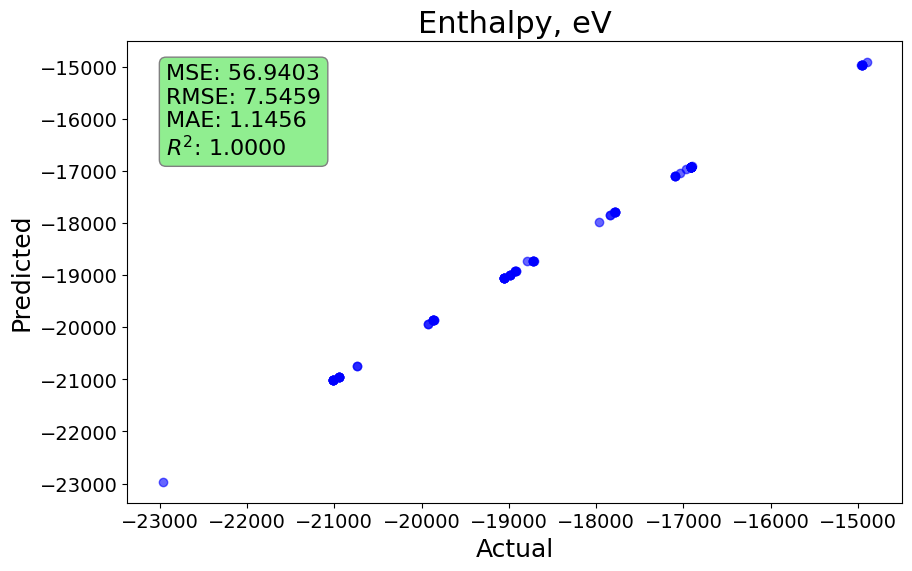

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.xlabel("Actual", fontsize=18)
plt.ylabel("Predicted", fontsize=18)
plt.title("Enthalpy, eV", fontsize=22)
plt.grid(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#-# Add metrics to the plot
metrics_text = f"MSE: {mse:.4f}\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\n$R^2$: {r2:.4f}"
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, fontsize=16, 
         verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='lightgreen'))

plt.show()

#-# Save actual and predicted values to a CSV file
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
results.to_csv('Decision_Tree(Act_vs_Pred).csv', index=False)